# Sentiment Analysis

In [95]:
# Import libraries
import pandas as pd
import numpy as np
import regex as re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import random
from tqdm import tqdm
tqdm.pandas()

# preprocessing 
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from langdetect import detect
from langdetect import DetectorFactory

# word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.mode.chained_assignment = None


from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from collections import Counter

<a id="0"></a>
#### Contents:
* [1. Dataset](#1)
    * [1.1. Loading Data](#1.1)
    * [1.2. Data Preprocessing](#1.2)
    * [1.3. Dataset Visualization](#1.3)
* [2. Lexicon based models](#2)
    * [2.1. VADER !!TODO:DELETE BEFORE SUBMISSION](#2.1)
    * [2.2. Model](#2.2)
    * [2.3. Evaluation](#2.3)
* [3. TextBlob Model](#3)
* [Advanced. Emotions in data](#advanced)

<a id="1"></a>
[<font size="+2" ><b>1. Dataset Presentation</b></font><br>](#0)

It is wise to explore our dataset first

<a id="1.1"></a>
[<font size="+1" ><b>1.1. Loading Data</b></font><br>](#0)
Load necessary data.

In [96]:
# Read csv file
df = pd.read_csv('dataset_transformed.csv', encoding='latin')
df_test = pd.read_csv('compiled_tweets.csv')
df.head()

,UserName,ScreenName,Location,TweetAt,Text,Sentiment,Subjectivity,Polarity
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1,NaN
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,0,1.0
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,0,1.0
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,0,1.0
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,0.0


In [97]:
# Removing unused columns
df = df[["Text", "Subjectivity", "Polarity"]]
df_test = df_test[["Text", "Subjectivity", "Polarity"]]
df_test = df_test[df['Subjectivity'].notna()].copy()
df.head()

C:\Users\ytchen\AppData\Local\Temp\ipykernel_112308\3724654528.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = df_test[df['Subjectivity'].notna()].copy()


,Text,Subjectivity,Polarity
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,NaN
1,advice Talk to your neighbours family to excha...,0,1.0
2,Coronavirus Australia: Woolworths to give elde...,0,1.0
3,My food stock is not the only one which is emp...,0,1.0
4,"Me, ready to go at supermarket during the #COV...",0,0.0


<a id="1.2"></a>
[<font size="+1" ><b>1.2. Data Preprocessing</b></font><br>](#0)

As twitter texts are relatively unclean compared with others, special cleaning are applied to remove emojis and links

In [98]:


# set seed
DetectorFactory.seed = 0

def language_detection(x):
    text = x['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e:
            try:
                # let's try to label it through the abstract then
                lang = detect(x['abstract'])
            except Exception as e:
                lang = "unknown"
                pass
    return lang

In [99]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    # text = re.sub(r'pic.twitter\S+', ' ', text)
    text = re.sub(r'#', '', text)
    text = text.lower()

    return text

def decontracted(text):
    text = re.sub(r"won\’t", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"can\’t", "can not", text)
    text = re.sub(r"n\’t", " not", text)
    text = re.sub(r"\’re", " are", text)
    text = re.sub(r"it\'s", "it is", text)
    text = re.sub(r"\’d", " would", text)
    text = re.sub(r"\’ll", " will", text)
    text = re.sub(r"\’t", " not", text)
    text = re.sub(r"\’ve", " have", text)
    text = re.sub(r"\’m", " am", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\’re", " are", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\’d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\’ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\’t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\’ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\’m", " am", text)
    text = re.sub(r"\“", "", text)
    text = re.sub(r"\”", "", text)
    text = re.sub(r"\…", "", text)

    return text


def remove_punc(tweet):
    tweet =  tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = ' '.join([word for word in tweet.split()])
    tweet = tweet.lower()
    
    return tweet

In [100]:
df['Text'] = df['Text'].apply(clean_text).apply(decontracted).apply(remove_punc)
df_test['Text'] = df_test['Text'].apply(clean_text).apply(decontracted).apply(remove_punc)
df.head()

,Text,Subjectivity,Polarity
0,menyrbie phil gahan chrisitv t co ifz fan pa a...,1,NaN
1,advice talk to your neighbours family to excha...,0,1.0
2,coronavirus australia woolworths to give elder...,0,1.0
3,my food stock is not the only one which is emp...,0,1.0
4,me ready to go at supermarket during the covid...,0,0.0


### Stemming 

In [101]:
# nltk.download('punkt')
# nltk.download('stopwords')

def stem_text(x):
    stemmer = PorterStemmer()
    x = word_tokenize(x)
    stem = ''
    
    for i in x:
        stem += stemmer.stem(i) + ' '
        
    return stem

df['stemmed_text'] = df['Text'].apply(stem_text)
df_test['stemmed_text'] = df_test['Text'].apply(stem_text)
df.head()

,Text,Subjectivity,Polarity,stemmed_text
0,menyrbie phil gahan chrisitv t co ifz fan pa a...,1,NaN,menyrbi phil gahan chrisitv t co ifz fan pa an...
1,advice talk to your neighbours family to excha...,0,1.0,advic talk to your neighbour famili to exchang...
2,coronavirus australia woolworths to give elder...,0,1.0,coronaviru australia woolworth to give elderli...
3,my food stock is not the only one which is emp...,0,1.0,my food stock is not the onli one which is emp...
4,me ready to go at supermarket during the covid...,0,0.0,me readi to go at supermarket dure the covid o...


### Lemmatization

In [102]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

def lemmatize_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in tweet.split()]) for tweet in corpus]

df['lemmatized_text'] = lemmatize_text(df['Text'])
df_test['lemmatized_text'] = lemmatize_text(df_test['Text'])
df.head()

,Text,Subjectivity,Polarity,stemmed_text,lemmatized_text
0,menyrbie phil gahan chrisitv t co ifz fan pa a...,1,NaN,menyrbi phil gahan chrisitv t co ifz fan pa an...,menyrbie phil gahan chrisitv t co ifz fan pa a...
1,advice talk to your neighbours family to excha...,0,1.0,advic talk to your neighbour famili to exchang...,advice talk to your neighbour family to exchan...
2,coronavirus australia woolworths to give elder...,0,1.0,coronaviru australia woolworth to give elderli...,coronavirus australia woolworth to give elderl...
3,my food stock is not the only one which is emp...,0,1.0,my food stock is not the onli one which is emp...,my food stock is not the only one which is emp...
4,me ready to go at supermarket during the covid...,0,0.0,me readi to go at supermarket dure the covid o...,me ready to go at supermarket during the covid...


### Stopwords Removal

In [103]:
stop = stopwords.words('english')
additional_stopwords = ["'s","...","'ve","``","''","'m",'--',"'ll","'d", 'u', 'b', 'c', 'd', 'x', 'xf', 'f', 'p', 'xb']
stop = set(stop + additional_stopwords)

def remove_stopwords(x):
    x = word_tokenize(x)
    store_words = ''
    
    for i in x:
        if i not in stop:
            store_words += i + ' '
            
    return store_words

In [104]:
df['cleaned_text'] = df['Text'].apply(remove_stopwords)
df['cleaned_stemmed_text'] = df['stemmed_text'].apply(remove_stopwords)
df['cleaned_lemmatized_text'] = df['lemmatized_text'].apply(remove_stopwords)

df_test['cleaned_text'] = df_test['Text'].apply(remove_stopwords)
df_test['cleaned_stemmed_text'] = df_test['stemmed_text'].apply(remove_stopwords)
df_test['cleaned_lemmatized_text'] = df_test['lemmatized_text'].apply(remove_stopwords)

df.head()

,Text,Subjectivity,Polarity,stemmed_text,lemmatized_text,cleaned_text,cleaned_stemmed_text,cleaned_lemmatized_text
0,menyrbie phil gahan chrisitv t co ifz fan pa a...,1,NaN,menyrbi phil gahan chrisitv t co ifz fan pa an...,menyrbie phil gahan chrisitv t co ifz fan pa a...,menyrbie phil gahan chrisitv co ifz fan pa co ...,menyrbi phil gahan chrisitv co ifz fan pa co x...,menyrbie phil gahan chrisitv co ifz fan pa co ...
1,advice talk to your neighbours family to excha...,0,1.0,advic talk to your neighbour famili to exchang...,advice talk to your neighbour family to exchan...,advice talk neighbours family exchange phone n...,advic talk neighbour famili exchang phone numb...,advice talk neighbour family exchange phone nu...
2,coronavirus australia woolworths to give elder...,0,1.0,coronaviru australia woolworth to give elderli...,coronavirus australia woolworth to give elderl...,coronavirus australia woolworths give elderly ...,coronaviru australia woolworth give elderli di...,coronavirus australia woolworth give elderly d...
3,my food stock is not the only one which is emp...,0,1.0,my food stock is not the onli one which is emp...,my food stock is not the only one which is emp...,food stock one empty please panic enough food ...,food stock onli one empti pleas panic enough f...,food stock one empty please panic enough food ...
4,me ready to go at supermarket during the covid...,0,0.0,me readi to go at supermarket dure the covid o...,me ready to go at supermarket during the covid...,ready go supermarket covid outbreak paranoid f...,readi go supermarket dure covid outbreak becau...,ready go supermarket covid outbreak paranoid f...


<a id="1.3"></a>
[<font size="+1"><b>1.3. Data Visualization</b></font><br>](#0)

In [105]:
print("========== number of words in the corpus ==========")
print(f"Train set: {df['Text'].apply(lambda x: len(x.split())).sum()}")
print(f"Test set: {df_test['Text'].apply(lambda x: len(x.split())).sum()}")

print("========== after stemming ==========")
print(f"Train set: {df['stemmed_text'].apply(lambda x: len(x.split())).sum()}")
print(f"Test set: {df_test['stemmed_text'].apply(lambda x: len(x.split())).sum()}")

print("========== after lemmatization ==========")
print(f"Train set: {df['lemmatized_text'].apply(lambda x: len(x.split())).sum()}")
print(f"Test set: {df_test['lemmatized_text'].apply(lambda x: len(x.split())).sum()}")

print("========== after removal of stopwords ==========")
print(f"Train set: {df['cleaned_text'].apply(lambda x: len(x.split())).sum()}")
print(f"Test set: {df_test['cleaned_text'].apply(lambda x: len(x.split())).sum()}")

print("========== after stemming and removal of stopwords ==========")
print(f"Train set: {df['cleaned_stemmed_text'].apply(lambda x: len(x.split())).sum()}")
print(f"Test set: {df_test['cleaned_stemmed_text'].apply(lambda x: len(x.split())).sum()}")

print("========== after lemmatization and removal of stopwords ==========")
print(f"Train set: {df['cleaned_lemmatized_text'].apply(lambda x: len(x.split())).sum()}")
print(f"Test set: {df_test['cleaned_lemmatized_text'].apply(lambda x: len(x.split())).sum()}")

========== number of words in the corpus ==========
Train set: 1458526
Test set: 262955
========== after stemming ==========
Train set: 1459131
Test set: 263264
========== after lemmatization ==========
Train set: 1458526
Test set: 262955
========== after removal of stopwords ==========
Train set: 884088
Test set: 161909
========== after stemming and removal of stopwords ==========
Train set: 911211
Test set: 165993
========== after lemmatization and removal of stopwords ==========
Train set: 887982
Test set: 160707


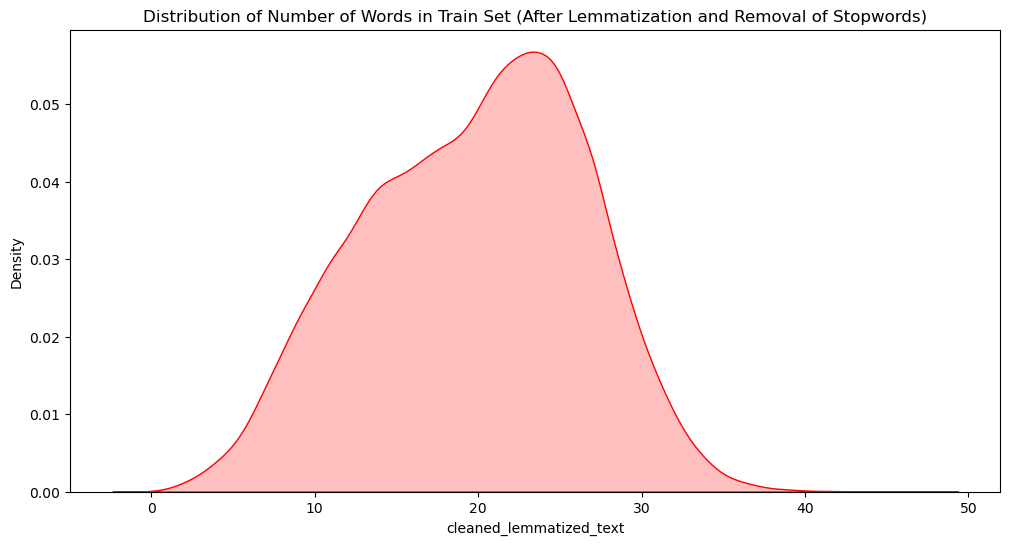

In [106]:
num_words_train = df['cleaned_lemmatized_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
p1=sns.kdeplot(num_words_train, fill=True, color="r").set_title('Distribution of Number of Words in Train Set (After Lemmatization and Removal of Stopwords)')

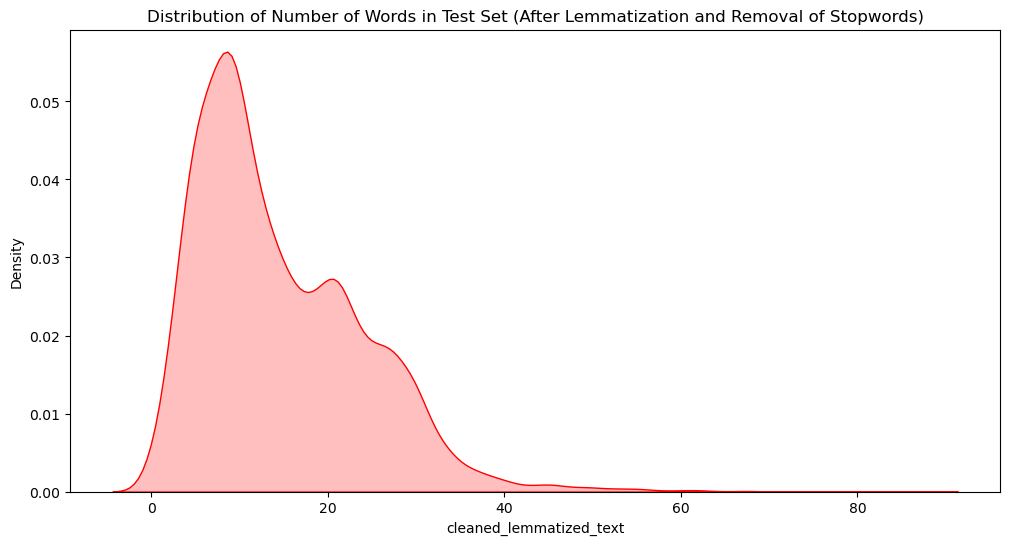

In [107]:
num_words_test = df_test['cleaned_lemmatized_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
p1=sns.kdeplot(num_words_test, fill=True, color="r").set_title('Distribution of Number of Words in Test Set (After Lemmatization and Removal of Stopwords)')

In [108]:
word_list_train = df.cleaned_lemmatized_text.str.split()
top = Counter([item for sublist in word_list_train for item in sublist])
temp = pd.DataFrame(top.most_common(15))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,covid,26192
1,co,26043
2,coronavirus,19736
3,store,9536
4,price,9536
5,food,8754
6,supermarket,8421
7,grocery,7679
8,people,6455
9,amp,5808


In [109]:
word_list_test = df_test.cleaned_lemmatized_text.str.split()
top = Counter([item for sublist in word_list_test for item in sublist])
temp = pd.DataFrame(top.most_common(15))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,co,4107
1,gta,3473
2,game,2954
3,pubg,1192
4,team,1180
5,naraka,1152
6,csgo,1112
7,lost,1071
8,playrust,1068
9,ark,1044


In [110]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color=color,
                    stopwords = STOPWORDS,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

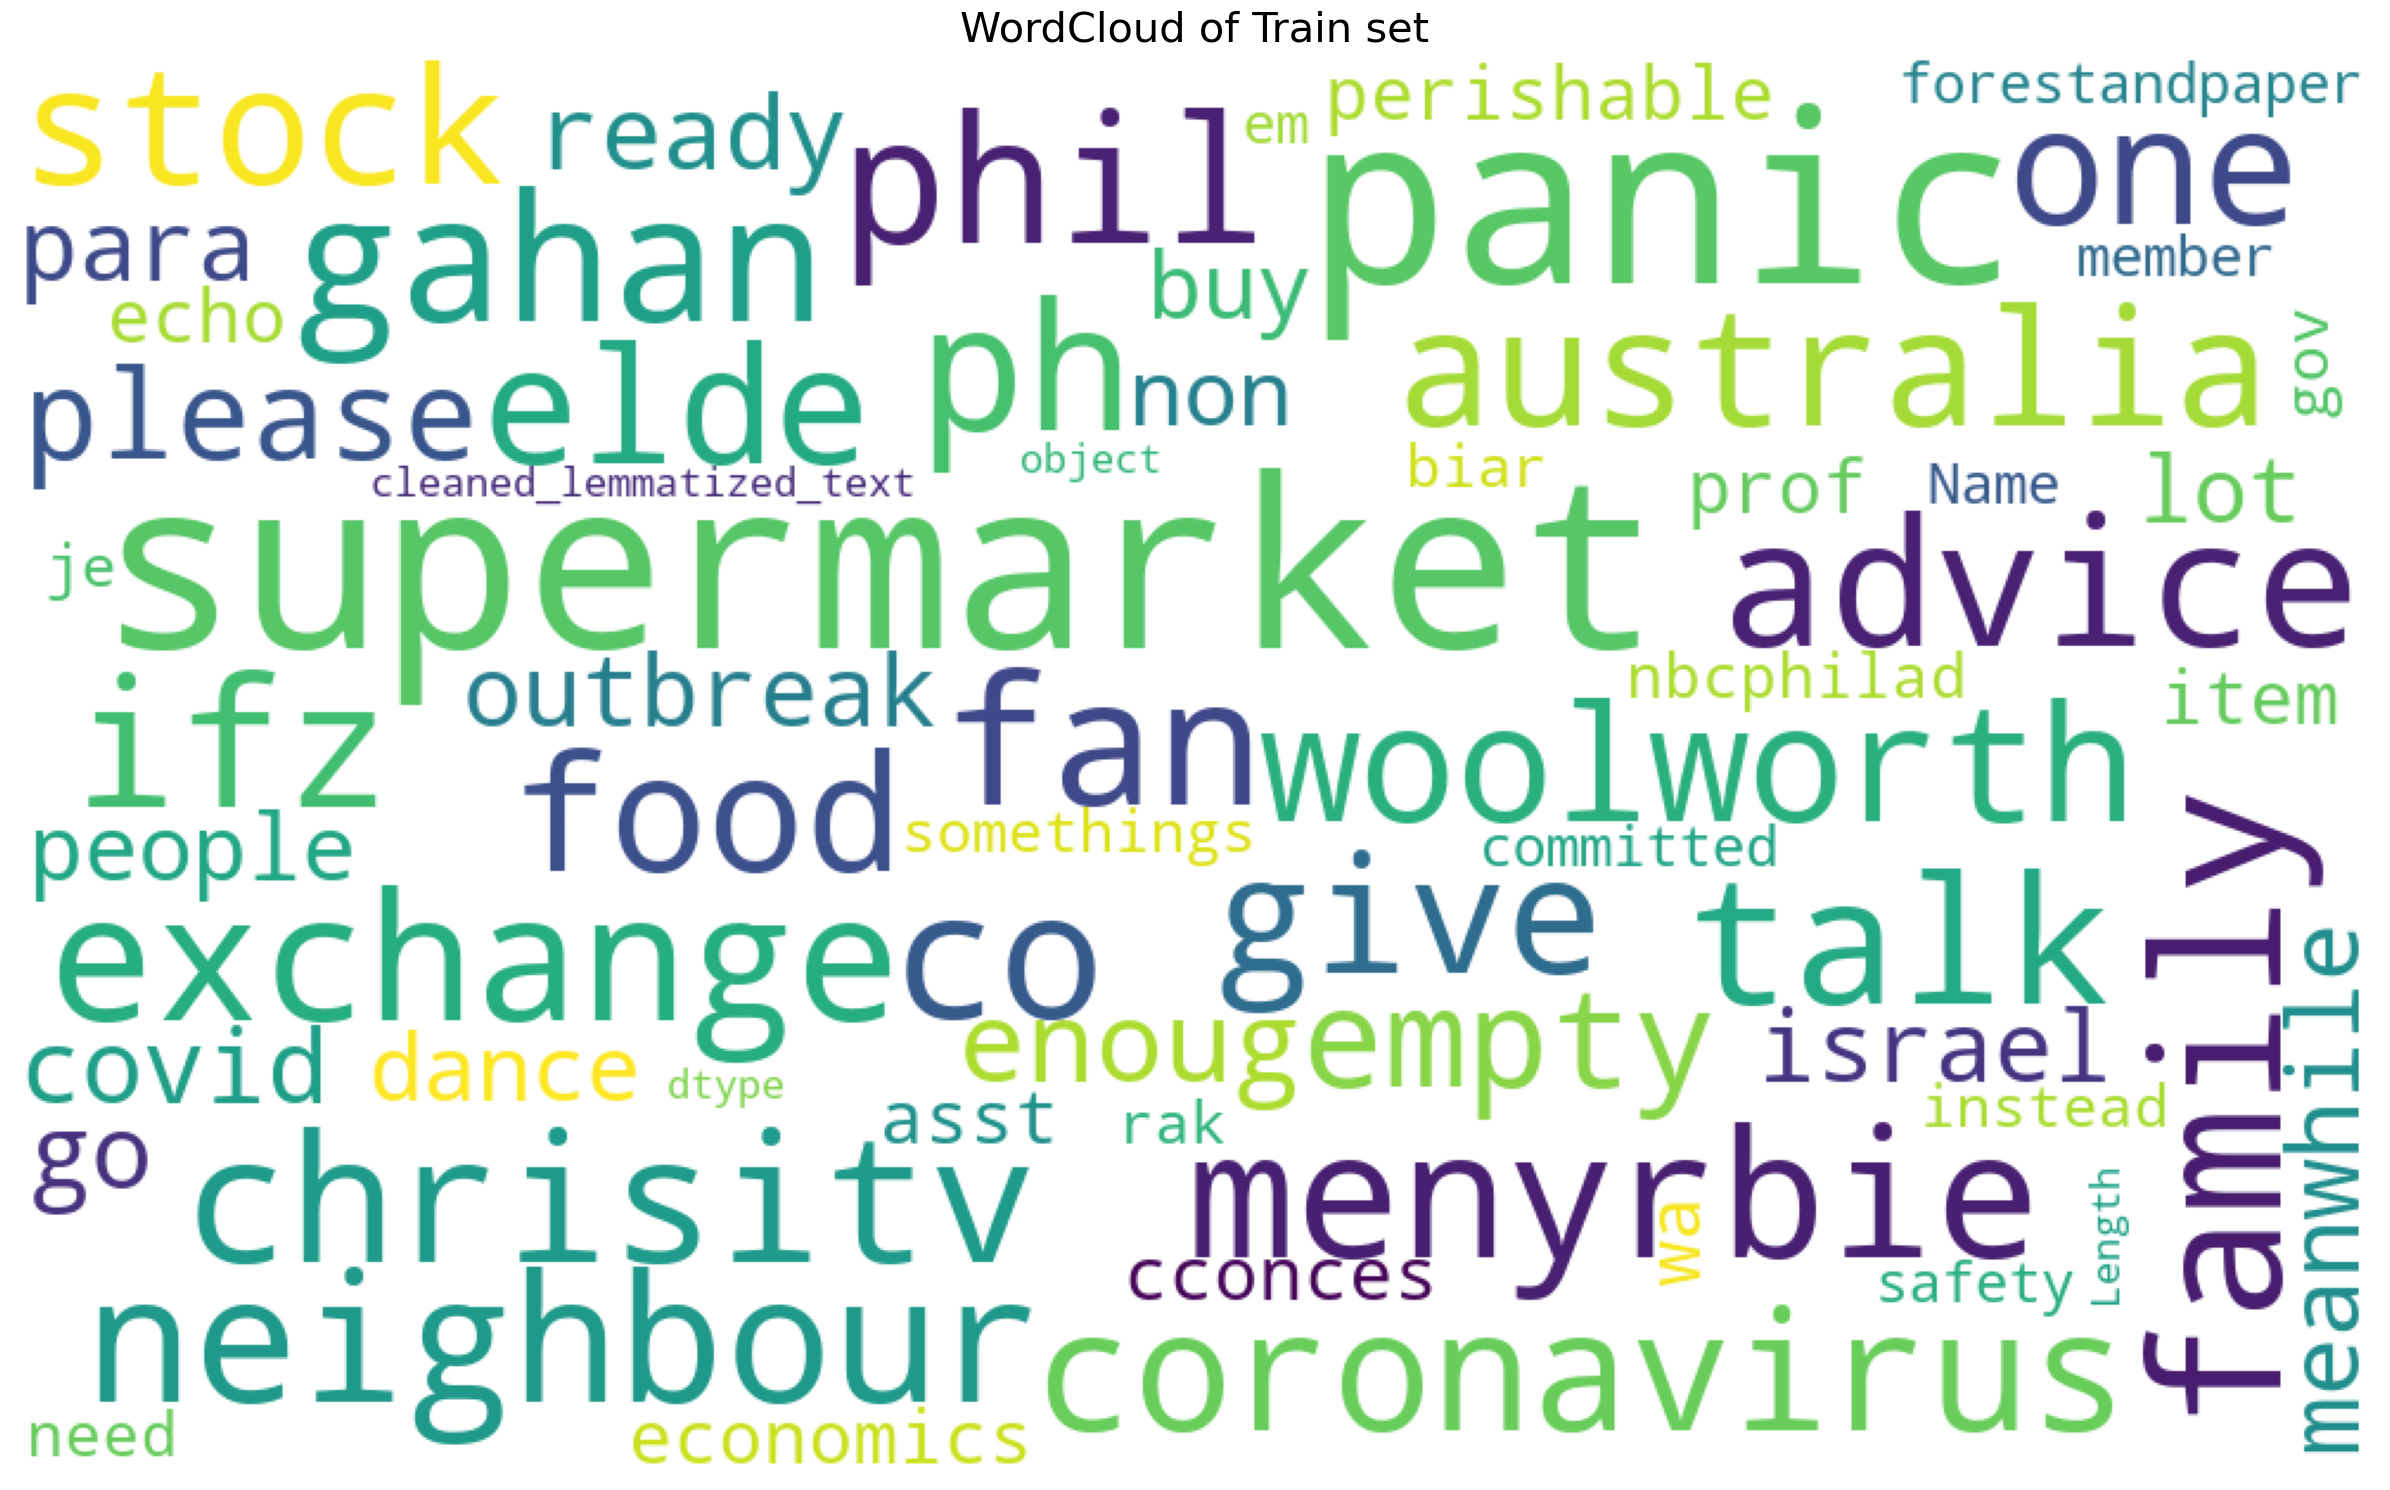

In [111]:
pos_mask = np.array(Image.new('RGB', (1000,600)))
plot_wordcloud(word_list_train, mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Train set")

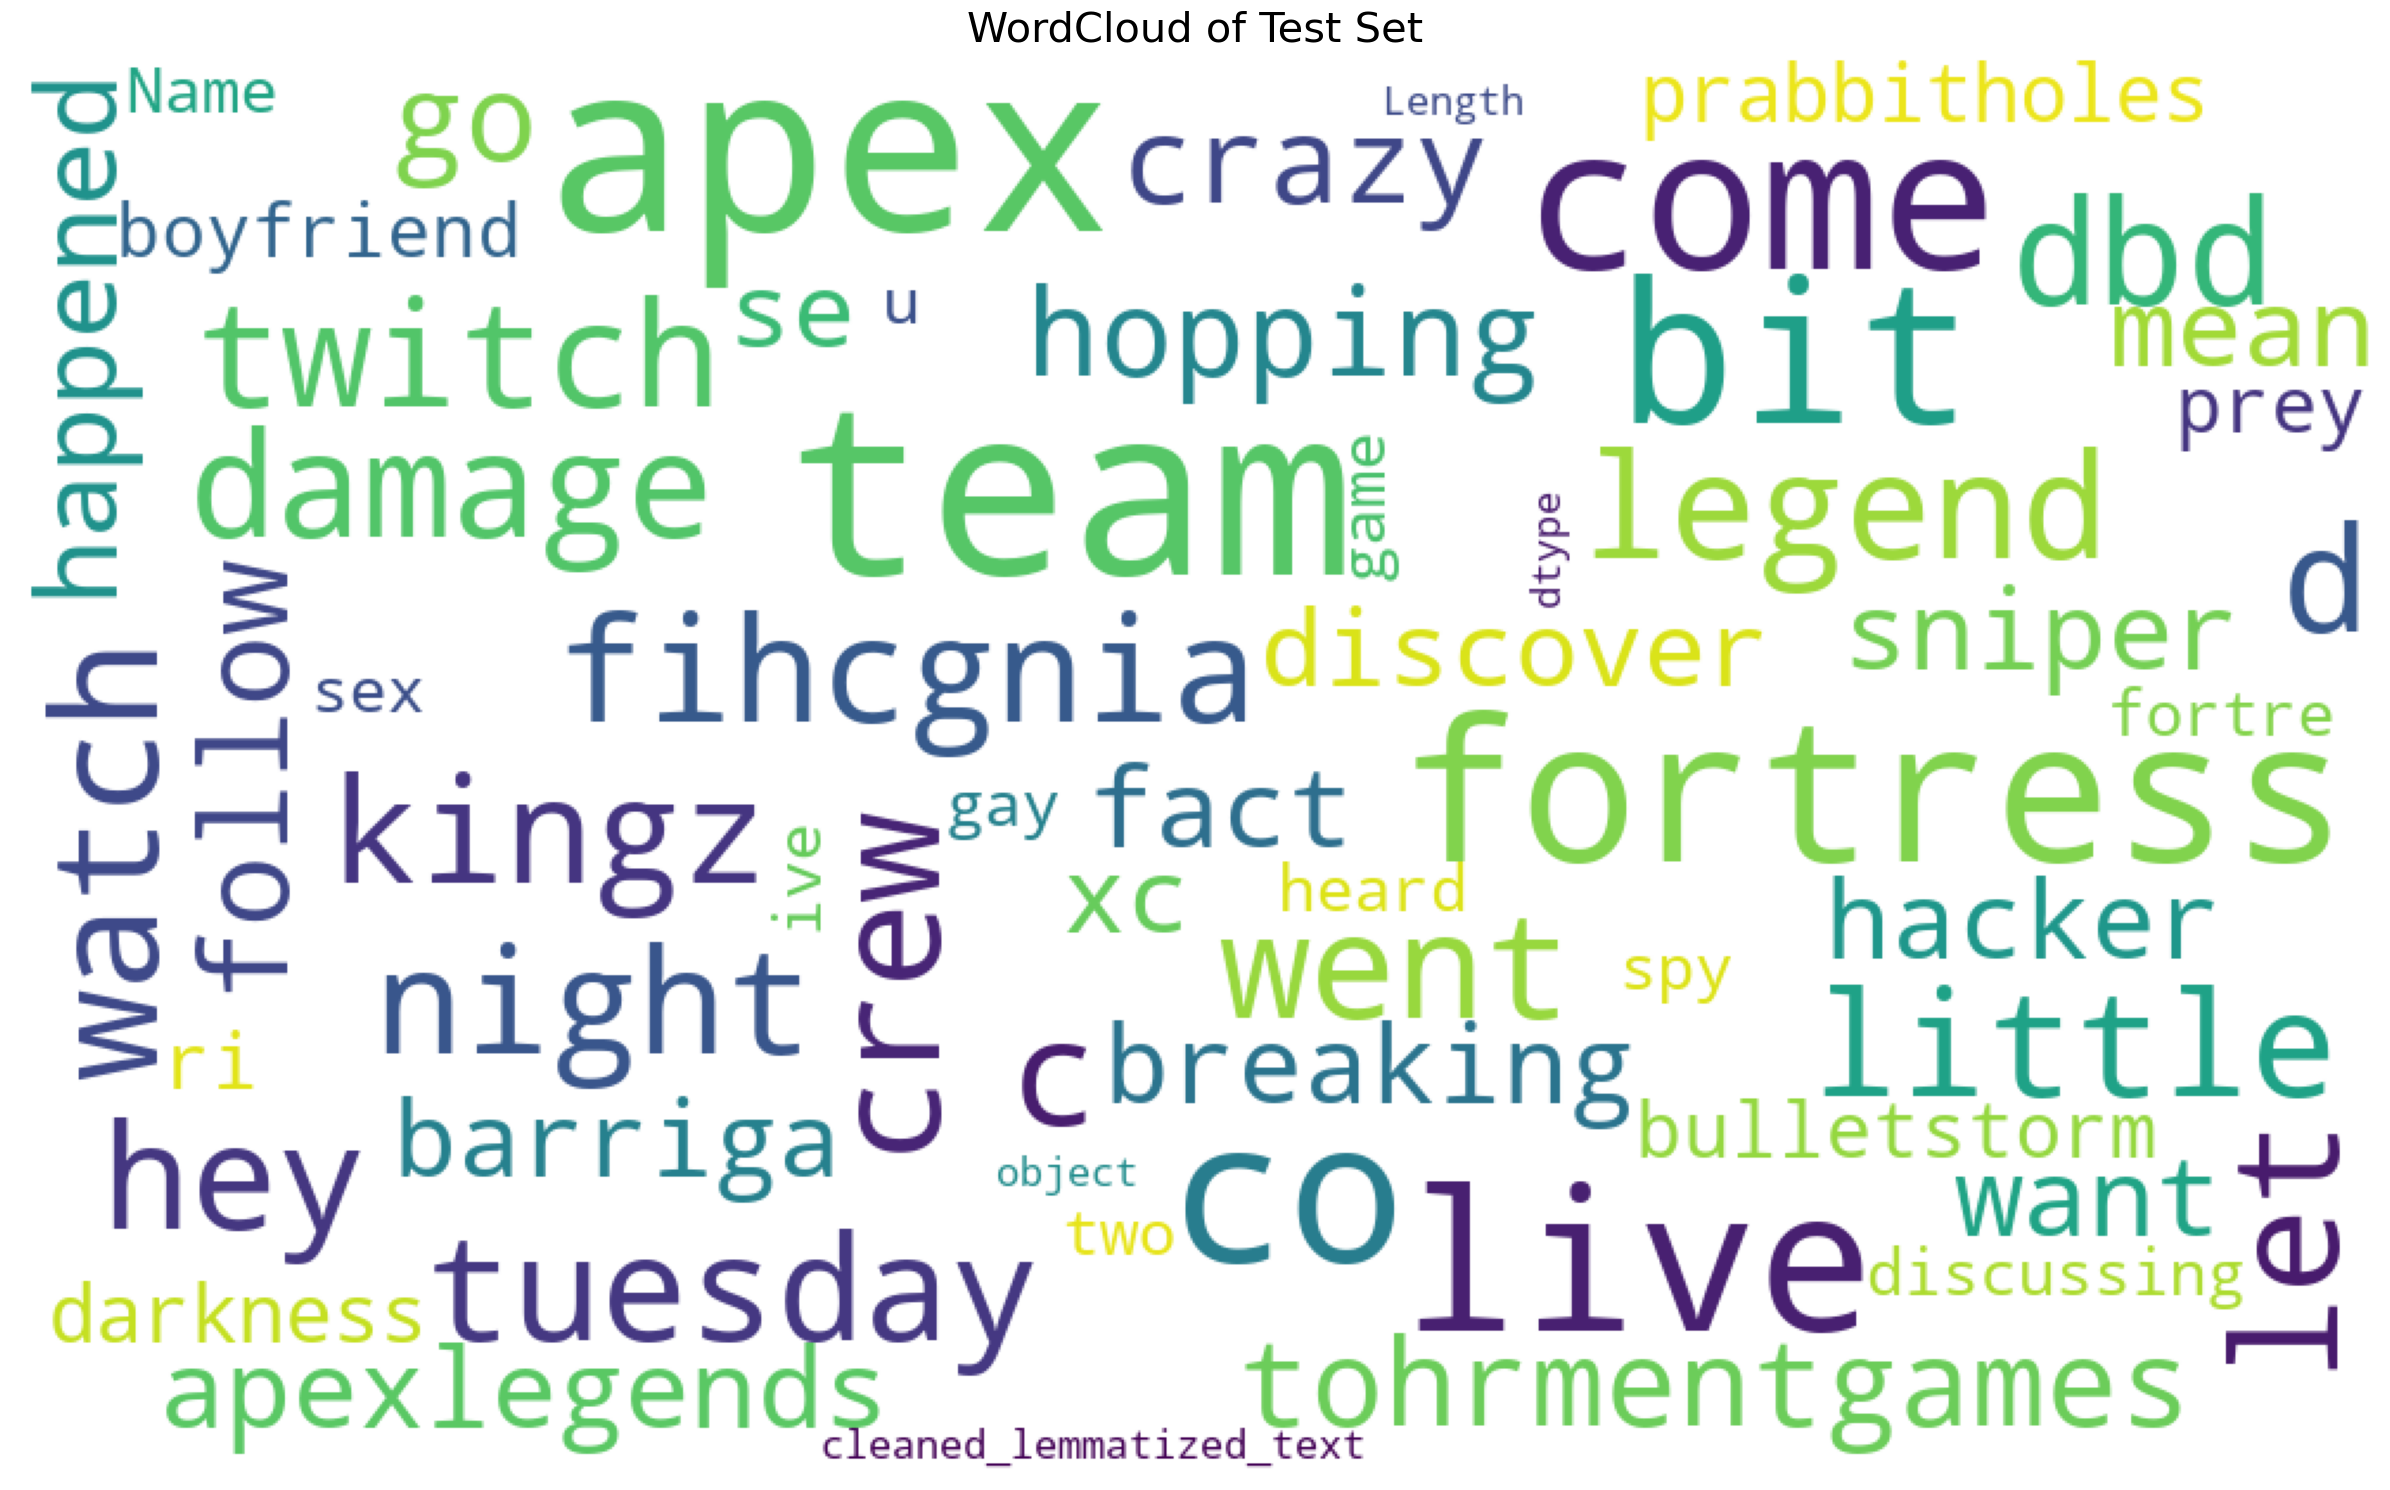

In [112]:
pos_mask = np.array(Image.new('RGB', (1000,600)))
plot_wordcloud(word_list_test, mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Test Set")

# **Naive Bayes Classification**

In [89]:
def naiveBayesClassification(x_train, x_test, y_train, y_test, preprocessing):

    naiveBayes_model = MultinomialNB().fit(tweet_matrix, y_train)
    result = naiveBayes_model.predict(test_vector)
    confuse = metrics.confusion_matrix(y_test, result)
    
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Naive Bayes Classification")
    print("Preprocessing Function: ", preprocessing)
    print("==================================================")
    print()
    plt.title("Confusion matrix of Naive Bayes Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    time.sleep(3)
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score = metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)
    
    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()
    

    

# **K-Nearest Neighbour (KNN) Classification**

In [90]:
def KNNClassification(x_train, x_test, y_train, y_test, preprocessing):
    
    metric = ['euclidean', 'manhattan', 'cosine']
    neighbors = list(range(1,30))
    leaf_size = list(range(1,50))
    weight = ['uniform', 'distance']
    param_grid = {'metric' : metric, 'n_neighbors': neighbors, 'weights' : weight, 'leaf_size' : leaf_size}
    
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)
    grid_search.fit(test_vector, y_test)
    
    
    knn_model = KNeighborsClassifier(n_neighbors = grid_search.best_params_['n_neighbors'], metric= grid_search.best_params_['metric'], leaf_size = grid_search.best_params_['leaf_size'], weights = grid_search.best_params_['weights'])
    knn_model.fit(tweet_matrix, y_train)   
    
    result = knn_model.predict(test_vector)
    confuse = metrics.confusion_matrix(y_test, result)
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: K-Nearest Neighbour Classification")
    print("Best parameters:", grid_search.best_params_)
    print("Preprocessing Function: ", preprocessing)
    print("==================================================")
    print()
    plt.title("Confusion matrix of KNN Classification of tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()
  

# **Support Vector Machine (SVM) Classification**

In [91]:
def SVMClassification(x_train, x_test, y_train, y_test, preprocessing):

    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.05, 0.1, 0.15, 0.20, 0.25]
    degrees = [0, 1, 2, 3, 4, 5, 6]
    kernels = ['rbf', 'linear', 'poly']
    param_grid = {'C': Cs, 'gamma' : gammas, 'degree' : degrees, 'kernel' : kernels}
    
    grid_search = GridSearchCV(svm.SVC(), param_grid, cv = 3)
    grid_search.fit(test_vector, y_test)
    grid_search.best_params_

    SVM_model = svm.SVC(C = grid_search.best_params_['C'], kernel = grid_search.best_params_['kernel'], gamma = grid_search.best_params_['gamma'], degree = grid_search.best_params_['degree'])
    SVM_model.fit(tweet_matrix, y_train)
    
    result = SVM_model.predict(test_vector)
    confuse = metrics.confusion_matrix(y_test, result)
    
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Support Vector Machine Classification")
    print("Preprocessing Function: ", preprocessing)
    print("Best parameters:", grid_search.best_params_)
    print("==================================================")
    print()
    plt.title("Confusion matrix of SVM Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()

# **Decision Tree Classification**

In [92]:
def decisionTreeClassification(x_train, x_test, y_train, y_test, preprocessing):
    
    clf = DecisionTreeClassifier() 

    param_grid = { 
        'criterion': ['gini','entropy'],
        'splitter': ['best','random'],
        'max_features': ['sqrt','log2']
    }
    
    grid_search = GridSearchCV(clf, param_grid, cv= 3)
    grid_search.fit(test_vector, y_test)
    grid_search.best_params_

    decisionTree_model = DecisionTreeClassifier(criterion = grid_search.best_params_['criterion'],splitter = grid_search.best_params_['splitter'], max_features = grid_search.best_params_['max_features'])
    decisionTree_model.fit(tweet_matrix, y_train)

    result = decisionTree_model.predict(test_vector)
    confuse = metrics.confusion_matrix(y_test, result)


    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Decision Tree Classification")
    print("Preprocessing Function: ", preprocessing)
    print("Best parameters:", grid_search.best_params_)
    print("==================================================")
    print()
    plt.title("Confusion matrix of Decision Tree Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()

# ***Subjectivity Classification*** 

Model: Naive Bayes Classification
Preprocessing Function:  Text



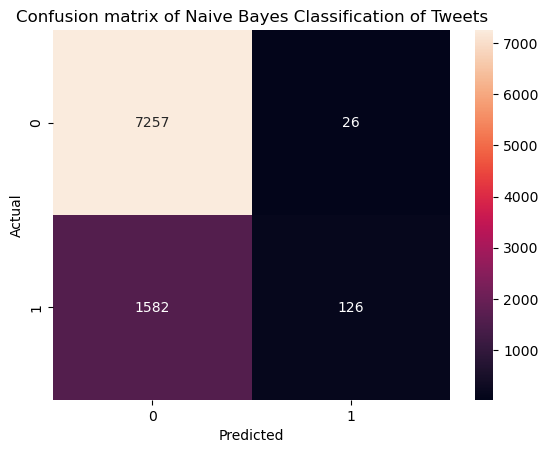

KeyboardInterrupt: 

In [93]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

preprocessings = ['Text', 'stemmed_text', 'cleaned_stemmed_text', 'lemmatized_text', 'cleaned_lemmatized_text', 'cleaned_text'] 
#Count Vectorizer
for preprocessing in preprocessings:
    x_train, x_test, y_train, y_test = train_test_split(df[[preprocessing]], 
                                                        df['Subjectivity'],
                                                        test_size = 0.2, 
                                                        random_state = 24)
    
    vectorizer = CountVectorizer(ngram_range=(1,2))
    tweet_matrix = vectorizer.fit_transform(x_train[preprocessing])
    test_vector = vectorizer.transform(x_test[preprocessing])
    
    naiveBayesClassification(x_train, x_test, y_train, y_test, preprocessing)
    time.sleep(2)

In [ ]:
#TF-IDF
for preprocessing in preprocessings:
    x_train, x_test, y_train, y_test = train_test_split(df[[preprocessing]], 
                                                        df['Subjectivity'],
                                                        test_size = 0.2, 
                                                        random_state = 24)
    
    vectorizer = TfidfVectorizer(use_idf = True, sublinear_tf = True)
    tweet_matrix = vectorizer.fit_transform(x_train[preprocessing])
    test_vector = vectorizer.transform(x_test[preprocessing])
    
    naiveBayesClassification(x_train, x_test, y_train, y_test, preprocessing)

In [ ]:
# Best F1 score with cleaned_text & count vectorizer
preprocessing = 'cleaned_text'
x_train, x_test, y_train, y_test = train_test_split(df[[preprocessing]], 
                                                    df['Subjectivity'],
                                                    test_size = 0.2, 
                                                    random_state = 24)
    
vectorizer = CountVectorizer(ngram_range=(1,2))
tweet_matrix = vectorizer.fit_transform(x_train[preprocessing])
test_vector = vectorizer.transform(x_test[preprocessing])
    
naiveBayesClassification(x_train, x_test, y_train, y_test, preprocessing)

In [ ]:
KNNClassification(x_train, x_test, y_train, y_test, preprocessing)

In [ ]:
SVMClassification(x_train, x_test, y_train, y_test, preprocessing)

In [ ]:
decisionTreeClassification(x_train, x_test, y_train, y_test, preprocessing)

# Polarity Classification

In [ ]:
df = df[df["Polarity"].notna()]
df.head()

In [ ]:
preprocessings = ['Text', 'stemmed_text', 'cleaned_stemmed_text', 'lemmatized_text', 'cleaned_lemmatized_text', 'cleaned_text'] 
#Count Vectorizer
for preprocessing in preprocessings:
    x_train, x_test, y_train, y_test = train_test_split(df[[preprocessing]], 
                                                        df['Polarity'],
                                                        test_size = 0.2, 
                                                        random_state = 24)
    
    vectorizer = CountVectorizer(ngram_range=(1,2))
    tweet_matrix = vectorizer.fit_transform(x_train[preprocessing])
    test_vector = vectorizer.transform(x_test[preprocessing])
    
    naiveBayesClassification(x_train, x_test, y_train, y_test, preprocessing)
    time.sleep(2)

In [ ]:
#TF-IDF
for preprocessing in preprocessings:
    x_train, x_test, y_train, y_test = train_test_split(df[[preprocessing]], 
                                                        df['Polarity'],
                                                        test_size = 0.2, 
                                                        random_state = 24)
    
    vectorizer = TfidfVectorizer(use_idf = True, sublinear_tf = True)
    tweet_matrix = vectorizer.fit_transform(x_train[preprocessing])
    test_vector = vectorizer.transform(x_test[preprocessing])
    
    naiveBayesClassification(x_train, x_test, y_train, y_test, preprocessing)

In [ ]:
# Best F1 score with cleaned_lemmatized_text & count vectorizer
preprocessing = 'cleaned_lemmatized_text'
x_train, x_test, y_train, y_test = train_test_split(df[[preprocessing]], 
                                                    df['Polarity'],
                                                    test_size = 0.2, 
                                                    random_state = 24)
    
vectorizer = CountVectorizer(ngram_range=(1,2))
tweet_matrix = vectorizer.fit_transform(x_train[preprocessing])
test_vector = vectorizer.transform(x_test[preprocessing])

In [ ]:
naiveBayesClassification(x_train, x_test, y_train, y_test, preprocessing)

In [ ]:
KNNClassification(x_train, x_test, y_train, y_test, preprocessing)

In [ ]:
SVMClassification(x_train, x_test, y_train, y_test, preprocessing)

In [ ]:
decisionTreeClassification(x_train, x_test, y_train, y_test, preprocessing)